# Dota 2: Win Probability Prediction
https://www.kaggle.com/c/dota-2-win-probability-prediction/discussion
<br>
https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie/peer/J1SH8/proiekt-priedskazaniia-pobieditielia-v-onlain-ighrie

In [71]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

Dowlnoading data for train and data for test and selecting a target variable

In [72]:
X_train = pd.read_csv('features.csv', index_col='match_id')
y_train = X_train.radiant_win
X_test = pd.read_csv('features_test.csv', index_col='match_id')

Function MissingValuesTable showed how many values are missed in data (that is an object of DataFrame)

In [73]:
def MissingValuesTable(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        by='% of Total Values', ascending=False).round(1)
        print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There're " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [74]:
MissingValuesTable(X_train)

Selected dataframe has 108 columns.
There're 12 columns that have missing values.


,Missing Values,% of Total Values
first_blood_player2,43987,45.2
radiant_flying_courier_time,27479,28.3
dire_flying_courier_time,26098,26.8
first_blood_time,19553,20.1
first_blood_team,19553,20.1
first_blood_player1,19553,20.1
dire_bottle_time,16143,16.6
radiant_bottle_time,15691,16.1
radiant_first_ward_time,1836,1.9
dire_first_ward_time,1826,1.9


Deleting of features that are not about the first 5 mins so they can impact on the result since they know the future

In [75]:
X_train.drop(['duration', 'radiant_win', 'tower_status_radiant',
           'tower_status_dire', 'barracks_status_radiant','barracks_status_dire'], axis=1, inplace=True)

### Simple Gradient Boosting classifier (Градиентный бустинг "в лоб")


In [76]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer

Filling missed values with a huge number.
<br>
This allows send objects containing missed values to another branch thus classification can be better.

In [77]:
imp = SimpleImputer(missing_values=np.nan, fill_value=1e9, strategy='constant')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)
#X_train.fillna(value=1e9, inplace=True)

Functon CrossValGBC let make cross validation on different count of trees(n_estimators).
<br>
It returns array of scores after cross_val_score and spent time.

In [78]:
def CrossValGBC(n):
    start_time = datetime.datetime.now()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    clf = GradientBoostingClassifier(n_estimators=n, random_state=42)
    quality = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=kf, scoring='roc_auc', n_jobs=-1)
    end_time = datetime.datetime.now()
    return quality, end_time-start_time


Let's test n = {10, 20, 30, 100} and save all in a dictionary where key is $n_i$ and value is a tuple of array of scores and spent time.

In [79]:
n_trees = [10, 20, 30, 100]
res = {}
for n in n_trees:
    res[n] = CrossValGBC(n)

In [88]:
for key, val in res.items():
    minutes, seconds = divmod(val[1].total_seconds(), 60)
    print("Count of trees: {0:3}, score on cross validation: {1:.10f}, spent time:{2:2.0f} mins and {3:.2f} sec"
          .format(key, val[0].mean(), minutes, seconds))

Count of trees:  10, score on cross validation: 0.6660340265, spent time: 0 mins and 44.39 sec
Count of trees:  20, score on cross validation: 0.6834568680, spent time: 1 mins and 14.81 sec
Count of trees:  30, score on cross validation: 0.6899489423, spent time: 1 mins and 55.62 sec
Count of trees: 100, score on cross validation: 0.7067004675, spent time: 5 mins and 37.21 sec


Let's fit our train sample and predict probabilities on test sample. 

In [23]:
gbclf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbclf.fit(X_train, y_train)
y_pred = gbclf.predict_proba(X_test)[:, 1]

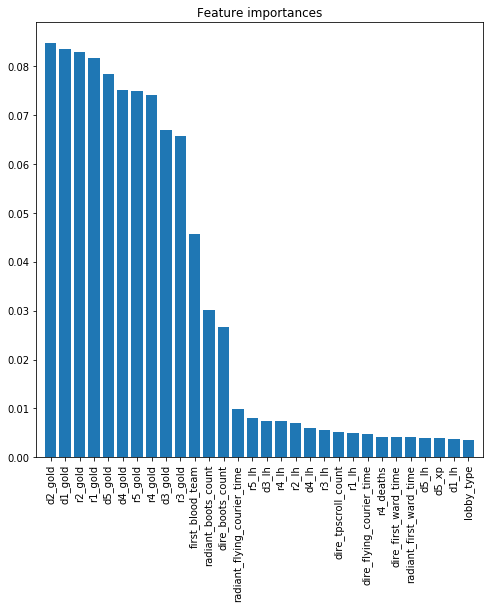

In [53]:
importances = gbclf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_first = 30
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(feat_first), importances[indices[:feat_first]], align='center')
plt.xticks(range(feat_first), np.array(feature_names)[indices[:feat_first]], rotation=90)
plt.xlim([-1, feat_first]);

In [99]:
best_features = indices[:13]
best_features_names = feature_names[best_features]
print(best_features_names)

Index(['d2_gold', 'd1_gold', 'r2_gold', 'r1_gold', 'd5_gold', 'd4_gold',
       'r5_gold', 'r4_gold', 'd3_gold', 'r3_gold', 'first_blood_team',
       'radiant_boots_count', 'dire_boots_count'],
      dtype='object')
